# Proyecto Inteligencia Computacional - Proyecto 8 - ID 8a

## Integrantes
- Juan Pablo Contreras
- Pascual Marcone

## Ayudante
- Sebastian Guzman

# Dependencias

In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
from torch.utils.data import TensorDataset
importlib.reload(src)

<module 'src' (namespace) from ['/home/pascual/inteli/proyecto/src']>

# Data access

In [2]:
#load everything
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')
dataset_1_21 = pd.read_pickle('data/stamp_dataset_21_new.pkl')
dataset_2_28 = pd.read_pickle('data/stamp_dataset_28.pkl')
dataset_2_45 = pd.read_pickle('data/stamp_dataset_45.pkl')
dataset_1_45 = pd.read_pickle('data/stamp_dataset_jun_allwise_45_final.pkl')
dataset_2_63 = pd.read_pickle('data/stamp_dataset_only_images_63.pkl')
dataset_1_63 = pd.read_pickle('data/td_ztf_stamp_17_06_20.pkl')

In [3]:
#changing all labels to match for ease of use in the future
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

# apply the function to 
rename_labels(stamps_dataset, 'labels', 'class')
# rename_labels(dataset_1_63, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

## Data Characterization

In [4]:
from anytree import Node, RenderTree

# stamps_dataset
root = Node(f"stamps_dataset -- {stamps_dataset['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("labels", parent=train)
images = Node("images", parent=train)
template = Node("template", parent=train)
difference = Node("difference", parent=train)

s_labels = Node("labels", parent=validation)
s_images = Node("images", parent=validation)
s_template = Node("template", parent=validation)
s_difference = Node("difference", parent=validation)

t_labels = Node("labels", parent=test)
t_images = Node("images", parent=test)
t_template = Node("template", parent=test)
t_difference = Node("difference", parent=test)

# Render the tree
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_1_21
root = Node(f"dataset_1_21 -- {dataset_1_21['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_2_28
root = Node(f"dataset_2_28 -- {dataset_2_28['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_2_45
root = Node(f"dataset_2_45 -- {dataset_2_45['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_1_45
root = Node(f"dataset_1_45 -- {dataset_1_45['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_2_63
root = Node(f"dataset_2_63 -- {dataset_2_63['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# dataset_1_63
root = Node(f"dataset_1_63 -- {dataset_1_63['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
images = Node("features", parent=train)
difference = Node("labels", parent=train)

s_labels = Node("images", parent=validation)
s_images = Node("features", parent=validation)
s_difference = Node("labels", parent=validation)

t_labels = Node("images", parent=test)
t_images = Node("features", parent=test)
t_difference = Node("labels", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))

stamps_dataset -- (123227, 5, 21, 21)
├── Train
│   ├── labels
│   ├── images
│   ├── template
│   └── difference
├── validation
│   ├── labels
│   ├── images
│   ├── template
│   └── difference
└── Test
    ├── labels
    ├── images
    ├── template
    └── difference


dataset_1_21 -- (72710, 21, 21, 3)
├── Train
│   ├── images
│   ├── features
│   ├── oid
│   └── class
├── validation
│   ├── images
│   ├── features
│   ├── oid
│   └── class
└── Test
    ├── images
    ├── features
    ├── oid
    └── class


dataset_2_28 -- (50594, 28, 28, 3)
├── Train
│   ├── images
│   ├── features
│   ├── oid
│   └── class
├── validation
│   ├── images
│   ├── features
│   ├── oid
│   └── class
└── Test
    ├── images
    ├── features
    ├── oid
    └── class


dataset_2_45 -- (50594, 45, 45, 3)
├── Train
│   ├── images
│   ├── features
│   ├── oid
│   └── class
├── validation
│   ├── images
│   ├── features
│   ├── oid
│   └── class
└── Test
    ├── images
    ├── features
    ├── oid
    └── c

# Visualizacion Datos
Hay 3 tipos de imagenes $21\cdot21$, $28\cdot28$, $45\cdot45$ y $63\cdot63$

In [33]:
print(dataset_2_45['Train']['features'].shape)

(50594, 23)


Analizando algunos ejemplos de cada una

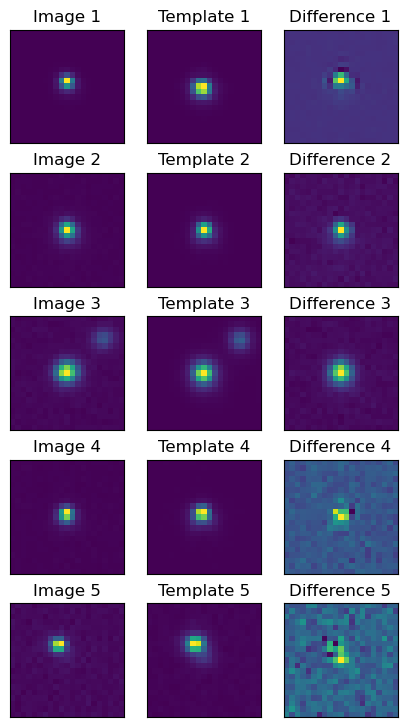

In [5]:
import src.plots as plots
importlib.reload(plots)

plots.plot_example(stamps_dataset, n = 5)

# Data Loader

In [ ]:
train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
train_class = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)

validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
validation_class = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)

test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)
test_class = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

# Reshape the arrays
num_samples, num_photos, height, width = train_difference.shape

reshaped_train_difference = train_difference.reshape(num_samples * num_photos, 1, height, width)
reshaped_train_class = train_class.repeat_interleave(num_photos)

num_samples, num_photos, height, width = validation_difference.shape

reshaped_val_difference = validation_difference.reshape(validation_difference.shape[0] * num_photos, 1, height, width)
reshaped_val_class = validation_class.repeat_interleave(num_photos)

num_samples, num_photos, height, width = test_difference.shape

reshaped_test_difference = test_difference.reshape(test_difference.shape[0] * num_photos, 1, height, width)
reshaped_test_class = test_class.repeat_interleave(num_photos)

train_dataset = TensorDataset(reshaped_train_difference, reshaped_train_class)
validation_dataset = TensorDataset(reshaped_val_difference, reshaped_val_class)
test_dataset = TensorDataset(reshaped_test_difference, reshaped_test_class)

print(train_dataset)

# Entrenamiento de Modelo

In [7]:
print(reshaped_train_difference.shape)
reshaped_train_difference[:1280].shape

torch.Size([616135, 1, 21, 21])


torch.Size([1280, 1, 21, 21])

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


TypeError: float() argument must be a string or a real number, not 'builtin_function_or_method'

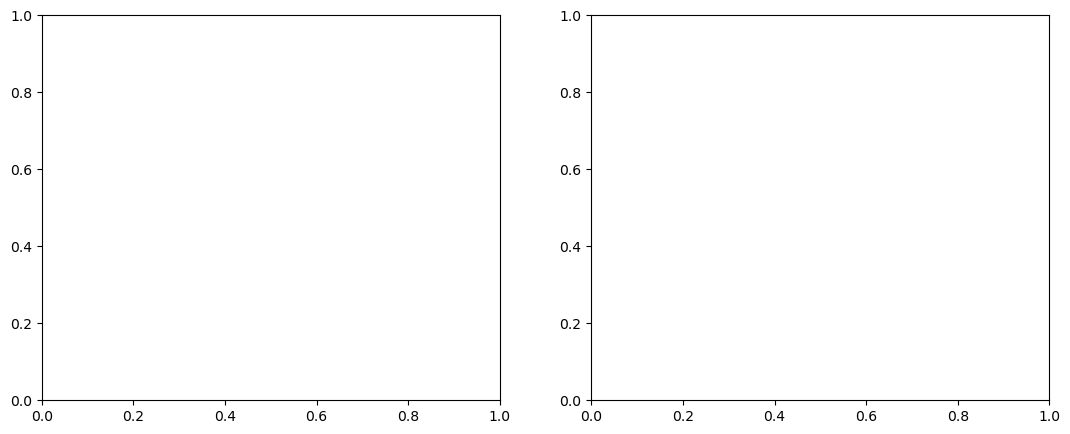

In [8]:
import src.model.train as train
importlib.reload(train)

import src.model.metrics as metrics
importlib.reload(metrics)

import src.model.vae as vae
importlib.reload(vae)

model = vae.VAE(latent_dim=21)

small_train_dataset = TensorDataset(reshaped_train_difference[:1280], reshaped_train_class[:1280])

small_validation_dataset = TensorDataset(reshaped_val_difference[:1280], reshaped_val_class[:1280]) 

max_epochs = 30
criterion = vae.loss_function
batch_size = 128
lr = 1e-4
early_stop = 20
use_gpu = False

curves, tiempo_ejecucion = train.train_model(model,
                                            small_train_dataset,
                                            small_validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu) #falta definir los parámetros

curves_fig = metrics.show_curves(curves)

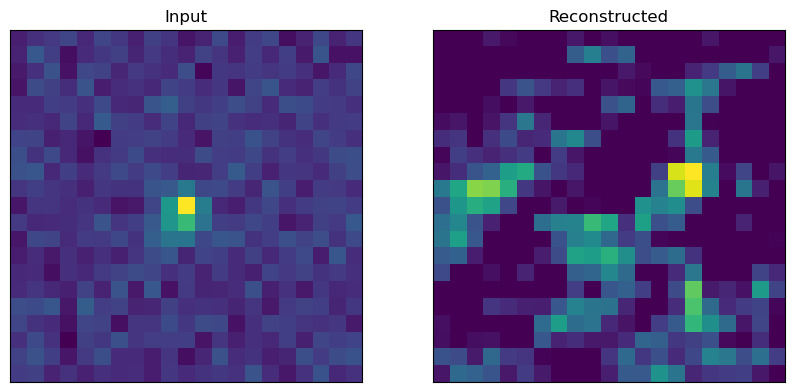

In [209]:
import src.plots as plots
importlib.reload(plots)

# Select an image from the dataset
image = dataset_1_21['Train']['images'][1, :, :, 0]
vector = dataset_1_21['Train']['features'][0]
# Convert the image to a tensor
image_tensor = torch.tensor(image, dtype=torch.float32)
# Add a batch dimension and channel dimension to the image tensor
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)

# Create a DataLoader for the image tensor
image_loader = torch.utils.data.DataLoader(image_tensor, batch_size=1)

import src.model.vae as vae
importlib.reload(vae)

model = vae.VAE(latent_dim=21)

reconstructed_image = model.forward(image_tensor)

plots.plot_two_images(image, reconstructed_image[0][0][0].detach().numpy())